# **Problématique** :

---


Comment le prix au mètre carré varie-t-il en fonction de la localisation, de la surface et du type de bien immobilier en France ?

In [2]:
import requests
import pandas as pd
import time
import tqdm
import os
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px

**I. Récupération des annonces**

---

Ce script interroge l'API du site "Notaires Immobilier" dans le but de collecter 50 annonces par ville. Ces données brutes sont nettoyées avant d'être sauvegarder pour une analyse ultérieure.

In [ ]:
"""
SCRAPER IMMOBILIER
-----------------------------------------------------
Objectif : Garantir le nombre cible d'annonces pour CHAQUE ville.
Stratégie : Si la page 1 ne suffit pas (trop de déchets), le script
charge automatiquement les pages suivantes jusqu'à atteindre l'objectif.
"""

# --- CONFIGURATION ---
villes_cibles = {
    "Paris": "75", "Marseille": "13", "Lyon": "69",
    "Toulouse": "31", "Nice": "06",
    "Lille": "59", "Bordeaux": "33", "Rouen": "76",
    "Montpellier": "34", "Rennes": "35"
}

# Sur-collecte (Over-fetching) à 80 logements/ville pour compenser le taux de déchet prévu lors du Data Cleaning et garantir un dataset équilibré de 50 logements
OBJECTIF_PAR_VILLE = 80
MAX_PAGES = 4

base_url = "https://www.immobilier.notaires.fr/pub-services/inotr-www-annonces/v1/annonces"
headers = {'User-Agent': 'Mozilla/5.0'}

data_list = []

print(f"ÉTAPE 1 : Scraping avec Pagination (Cible : {OBJECTIF_PAR_VILLE}/ville)...")

if not os.path.exists("../DATA"):
    os.makedirs("../DATA")

# --- 2. BOUCLE PRINCIPALE ---
for nom_ville, code_dept in villes_cibles.items():
    print(f"   -> Analyse de {nom_ville} (Dept {code_dept})...")

    count_valid = 0
    current_page = 1

    # TANT QUE l'objectif n'est pas atteint ET qu'on n'a pas dépassé 4 pages
    while count_valid < OBJECTIF_PAR_VILLE and current_page <= MAX_PAGES:

        params = {
            'offset': (current_page - 1) * 100, # Décalage pour tourner les pages
            'page': current_page,
            'parPage': 100,
            'typeTransactions': 'VENTE',
            'departement': code_dept
        }

        try:
            response = requests.get(base_url, params=params, headers=headers)

            if response.status_code == 200:
                annonces = response.json().get('annonceResumeDto', [])

                # Si la page est vide, il n'y a plus rien à voir
                if not annonces:
                    print(f" Plus d'annonces disponibles page {current_page}.")
                    break

                for annonce in annonces:
                    if count_valid >= OBJECTIF_PAR_VILLE:
                        break

                    # --- FILTRES ---
                    prix = annonce.get('prixAffiche', 0)
                    surface = annonce.get('surface', 0)
                    cp = str(annonce.get('codePostal', ''))

                    if prix and prix > 1000 and surface and surface > 9 and cp.startswith(code_dept):

                        # --- TYPE ---
                        code_type = annonce.get('typeBien', 'INCONNU')
                        titre = annonce.get('descriptionFr', '')

                        if code_type == 'MAI': type_propre = 'Maison'
                        elif code_type == 'APP': type_propre = 'Appartement'
                        else:
                            if 'maison' in titre.lower(): type_propre = 'Maison'
                            elif 'appartement' in titre.lower(): type_propre = 'Appartement'
                            else: type_propre = 'Autre'

                        data_list.append({
                            'Ville_Recherche': nom_ville,
                            'Titre': titre, # Description complète
                            'Prix': prix,
                            'Surface_m2': surface,
                            'Pieces': annonce.get('nbPieces', 0),
                            'Type': type_propre,
                            'Ville_Reelle': annonce.get('communeNom'),
                            'CP': cp,
                            'Adresse_Texte': f"{annonce.get('communeNom')}, {cp}, France"
                        })
                        count_valid += 1

            else:
                break # Erreur API

        except Exception as e:
            print(f" Erreur : {e}")
            break

        # On passe à la page suivante si l'objectif n'est pas atteint
        if count_valid < OBJECTIF_PAR_VILLE:
            # print(f" Passage à la page {current_page + 1}...")
            current_page += 1
            time.sleep(0.2)

    print(f" Total validé : {count_valid} annonces.")

# Sauvegarde
df = pd.DataFrame(data_list)
output_path = "../DATA/data_brute.csv"
df.to_csv(output_path, index=False)
print(f"\n Terminé ! Fichier sauvegardé : {output_path}")
print(f" Total global : {len(df)} lignes.")

ÉTAPE 1 : Scraping avec Pagination (Cible : 80/ville)...
   -> Analyse de Paris (Dept 75)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Marseille (Dept 13)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Lyon (Dept 69)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Toulouse (Dept 31)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Nice (Dept 06)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Lille (Dept 59)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Bordeaux (Dept 33)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Rouen (Dept 76)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Montpellier (Dept 34)...
      ✅ Total validé : 80 annonces.
   -> Analyse de Rennes (Dept 35)...
      ✅ Total validé : 80 annonces.

🎉 Terminé ! Fichier sauvegardé : ../DATA/data_brute.csv
📊 Total global : 800 lignes.


**II. Le Script de Nettoyage & Géolocalisation**

---
Ce script reprend le fichier précédent, nettoie les prix/surfaces et ajoute les coordonnées GPS.


In [ ]:
"""
NETTOYAGE ET GÉOLOCALISATION
----------------------------
Ce script transforme les données brutes en données exploitables pour le Dashboard.
1. Nettoyage : Conversion des prix/surfaces en nombres.
2. Calculs : Création de la colonne Prix_m2.
3. Géolocalisation : Transformation des adresses en Latitude/Longitude.

Entrée : '../DATA/data_brute.csv'
Sortie : '../DATA/data_cleaning.csv'
"""

print("ÉTAPE 2 : Nettoyage et Géolocalisation...")

# Définition des chemins
input_path = "../DATA/data_brute.csv"
output_path = "../DATA/data_cleaning.csv"

# --- CHARGEMENT DES DONNÉES ---
if not os.path.exists(input_path):
    print(f" Erreur : Le fichier {input_path} est introuvable.")
    print(" Lance d'abord 'python3 scraper.py' pour le créer.")
    exit()

df = pd.read_csv(input_path)
print(f"   -> Chargement de {len(df)} annonces brutes.")

# --- NETTOYAGE ET CALCULS ---
print("   -> Nettoyage des formats numériques...")

# Conversion forcée en numérique (les erreurs deviennent NaN)
df['Prix'] = pd.to_numeric(df['Prix'], errors='coerce')
df['Surface_m2'] = pd.to_numeric(df['Surface_m2'], errors='coerce')

# Suppression des lignes incohérentes (Surface vide, prix nul ou surface < 9m²)
# La loi Carrez considère > 9m² comme logement décent.
df = df.dropna(subset=['Prix', 'Surface_m2'])
df = df[df['Surface_m2'] > 9]
df = df[df['Prix'] > 1000] # On retire les éventuels "loyers" ou erreurs

# Calcul de la variable clé : Prix au m²
df['Prix_m2'] = round(df['Prix'] / df['Surface_m2'], 2)

print(f"   -> {len(df)} annonces valides après nettoyage.")


ÉTAPE 2 : Nettoyage et Géolocalisation...
   -> Chargement de 800 annonces brutes.
   -> Nettoyage des formats numériques...
   -> 800 annonces valides après nettoyage.

🌍 Démarrage de la géolocalisation...
⚠️  ATTENTION : Cela va prendre environ 15-20 minutes (1 sec/adresse).


  0%|          | 0/800 [00:00<?, ?it/s]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
urllib3.exceptions.MaxRetryError: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Toulouse%2C+31400%2C+France&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/geopy/adapters.py", line 482, in _request
    resp = self.session.get(url, timeout=timeout, headers=headers)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/requests/sessions.py", line 589, in request

KeyboardInterrupt: 

In [ ]:
# --- GÉOLOCALISATION (GEOPY) ---
print("\n Démarrage de la géolocalisation...")
print("  ATTENTION : Cela va prendre environ 15-20 minutes (1 sec/adresse).")

# Initialisation du service de géocoding
geolocator = Nominatim(user_agent="projet_master_immo_2025_etudiant")

# RateLimiter est CRUCIAL : il impose une pause d'1 seconde entre chaque requête.
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.0)

# On utilise une barre de progression simple via Pandas si possible
# Sinon, on applique simplement la fonction
try:
    from tqdm.auto import tqdm
    tqdm.pandas() # Active la barre de progression pour Pandas
    df['location'] = df['Adresse_Texte'].progress_apply(geocode)
except ImportError:
    # Si tqdm n'est pas installé, on fait sans barre de progression
    print("   (Astuce : installe 'tqdm' pour voir une barre de progression)")
    df['location'] = df['Adresse_Texte'].apply(geocode)

# Extraction des coordonnées (Latitude / Longitude)
# Si 'location' est None (adresse pas trouvée), on met None
df['Latitude'] = df['location'].apply(lambda loc: loc.latitude if loc else None)
df['Longitude'] = df['location'].apply(lambda loc: loc.longitude if loc else None)

# Suppression des annonces qu'on n'a pas réussi à localiser
nb_avant = len(df)
df_final = df.dropna(subset=['Latitude', 'Longitude'])
nb_apres = len(df_final)

print(f"\n   -> Géolocalisation terminée. {nb_avant - nb_apres} adresses non trouvées (supprimées).")

# --- SÉLECTION ET SAUVEGARDE ---
# On ne garde que les colonnes utiles pour le Dashboard
colonnes_utiles = [
    'Ville_Recherche',
    'Ville_Reelle',
    'Type',
    'Prix',
    'Surface_m2',
    'Prix_m2',
    'Pieces',
    'Latitude',
    'Longitude'
]
df_final = df_final[colonnes_utiles]

# --- SAUVEGARDE FINALE ---
df_final.to_csv(output_path, index=False)
print(f"SUCCÈS ! Fichier prêt : {output_path} ({len(df_final)} lignes)")

**a. Vérification de la volumétrie par ville**

In [ ]:
# Charger le fichier
df = pd.read_csv("../DATA/data_cleaning.csv")

# Compter les valeurs dans la colonne 'Ville_Recherche'
comptes = df['Ville_Recherche'].value_counts()

print("Nombre d'annonces par ville :")
print(comptes)

**b. Échantillonnage aléatoire et création du dataset final**

In [ ]:
print("ÉTAPE 3 : Création du Dataset Final (50/ville) avec filtre pièces...")

input_path = "../DATA/data_cleaning.csv"
output_path = "../DATA/dataset_final.csv"

# Charger le fichier propre et géolocalisé
if not os.path.exists(input_path):
    print(f" Le fichier {input_path} n'existe pas. Lance l'étape 2 d'abord.")
    exit()

df = pd.read_csv(input_path)
print(f"   -> Chargement de {len(df)} annonces disponibles.")

# FILTRES SUPPLÉMENTAIRES
# On s'assure qu'il y a au moins 1 pièce
nb_avant_pieces = len(df)
df = df[df['Pieces'] >= 1]
nb_apres_pieces = len(df)
print(f"   -> Filtre 'Minimum 1 pièce' : {nb_avant_pieces - nb_apres_pieces} annonces supprimées.")

# Échantillonange (50 max par ville)
# On mélange de facon aléatoire (sample) puis on garde les 50 premières annonces par ville
df_50 = df.sample(frac=1, random_state=42).groupby("Ville_Recherche").head(50)

# 4. Réinitialiser l'index
dataset_final = df_50.reset_index(drop=True)

# 5. Vérification
print("\n Nouvelle répartition par ville (Cible : 50 max) :")
print(dataset_final['Ville_Recherche'].value_counts())

# 6. Sauvegarde
dataset_final.to_csv(output_path, index=False)
print(f"\n SUCCÈS ! Fichier final sauvegardé : {output_path} ({len(dataset_final)} lignes)")

**III. Analyse statistique**

---
Dans la suite du script, nous allons effectuer des analyses statistiques et mettre en lumière les tendances du marché immobilier dans chaque ville.

**Importation de la base de données**

In [4]:
# Indiquez simplement le nom de votre fichier ici
file_name = 'dataset_final.csv' 

# Vérification pour éviter les erreurs si le chemin est mauvais
if os.path.exists(file_name):
    print(f"Chargement du fichier : {file_name}")
    df = pd.read_csv(file_name)
    
    # Afficher les 5 premières lignes
    print("-" * 30)
    print("Aperçu des données :")
    display(df.head()) # 'display' est plus joli que 'print' dans un notebook
else:
    print(f"ERREUR : Le fichier '{file_name}' est introuvable.")
    print("Vérifiez qu'il est bien dans le même dossier que ce notebook.")

# --- CODE POUR GOOGLE COLAB  ---
# Si vous retournez sur Colab, décommentez les lignes ci-dessous :
# from google.colab import files
# print("Veuillez sélectionner le fichier à téléverser :")
# uploaded = files.upload()
# file_name = next(iter(uploaded))

Chargement du fichier : dataset_final.csv
------------------------------
Aperçu des données :


,Ville_Recherche,Ville_Reelle,Type,Prix,Surface_m2,Prix_m2,Pieces,Latitude,Longitude
0,Montpellier,Pomérols,Maison,287000,120.00,2391.67,4,43.390895,3.499216
1,Nice,Saint-Martin-du-Var,Maison,700000,163.15,4290.53,5,43.821970,7.191800
2,Rennes,Gévezé,Maison,340000,120.00,2833.33,5,48.220489,-1.789637
3,Montpellier,Montpellier,Maison,305286,112.10,2723.34,4,43.611242,3.876734
4,Lille,Flers-en-Escrebieux,Maison,189000,159.00,1188.68,5,50.397815,3.061421


In [5]:
df.shape

(500, 9)

**1. Nombre de maisons et d'appartements par ville**

In [6]:
# Compte par ville et par type de logement
counts = df.groupby(['Ville_Recherche', 'Type']).size().unstack(fill_value=0)

# Nettoyage des noms de colonnes
counts = counts.reset_index()
counts.rename(columns={'Ville_Recherche': 'Ville'}, inplace=True)

# Ajout d'une colonne Total
counts['Total'] = counts['Appartement'] + counts['Maison']
print(counts)

Type        Ville  Appartement  Maison  Total
0        Bordeaux            1      49     50
1           Lille            1      49     50
2            Lyon           28      22     50
3       Marseille           23      27     50
4     Montpellier           14      36     50
5            Nice           33      17     50
6           Paris           47       3     50
7          Rennes            0      50     50
8           Rouen           11      39     50
9        Toulouse            5      45     50


Nous avons collecté aléatoirement les 50 premières annonces du site Notaires immobilier, ce qui fait que nous nous retrouvons avec des statistiques pas forcément équilibré.

Pour la ville de Rennes par exemple, nous n'avons aucune donnée concernant les appartements. Bordeaux et Lille enregistrent une annonce concernant les appartements tandis que Toulouse en a 5.

**2. Moyenne et médiane du prix en fonction du type de logements par ville**

In [7]:
# Groupement et calcul des statistiques
stats_complet = df.groupby(['Ville_Recherche', 'Type'])['Prix'].agg(['mean', 'median', 'count']).reset_index()
stats_complet.columns = ['Ville', 'Type', 'Prix_Moyen', 'Prix_Median', 'Nombre_Total']

# Arrondi
stats_complet['Prix_Moyen'] = stats_complet['Prix_Moyen'].round(2)

# Séparation et tri par prix moyen croissant
maisons_tries = stats_complet[stats_complet['Type'] == 'Maison'].sort_values(by='Prix_Moyen')
apparts_tries = stats_complet[stats_complet['Type'] == 'Appartement'].sort_values(by='Prix_Moyen')

print(maisons_tries)
print(apparts_tries)

          Ville    Type  Prix_Moyen  Prix_Median  Nombre_Total
3         Lille  Maison   181022.86     150000.0            49
16        Rouen  Maison   224989.72     209000.0            39
18     Toulouse  Maison   274624.67     195000.0            45
5          Lyon  Maison   389307.64     387500.0            22
14       Rennes  Maison   425906.00     363000.0            50
9   Montpellier  Maison   433551.22     382039.0            36
1      Bordeaux  Maison   573753.65     380000.0            49
7     Marseille  Maison  1001920.78     480777.0            27
13        Paris  Maison  1294666.67    1444000.0             3
11         Nice  Maison  1356873.94     802000.0            17
          Ville         Type  Prix_Moyen  Prix_Median  Nombre_Total
2         Lille  Appartement    95000.00      95000.0             1
17     Toulouse  Appartement   147071.60     127358.0             5
0      Bordeaux  Appartement   150000.00     150000.0             1
15        Rouen  Appartement   1751

Pour les maisons en vente, le prix moyen de Lille, Rouen et Toulouse sont les plus faibles, tandis que Paris et Nice enregistrent les prix les plus élevés. L'écart est flagrant entre Lille (181 k€) et Nice (1,35 M€). On achète en moyenne 7 maisons à Lille pour le prix d'une seule à Nice.

Concernant les appartements, on retrouve toujours Lille et Toulouse pour les prix moyens les plus faibles et Nice et Paris sont les villes les plus onéreuses.

Le classement permet de voir où il est le plus facile de devenir propriétaire. Pour les appartements, Lille et Toulouse sont les plus accessibles (moyennes < 150 k€), alors que Paris demande un budget presque 10 fois supérieur (910 k€).

**3. Moyenne et médiane du prix au m²**

In [8]:
# Calcul de la moyenne et médiane du prix au m² par ville
stats_prix_m2 = df.groupby('Ville_Recherche')['Prix_m2'].agg(['mean', 'median']).reset_index()

# Classement par prix moyen (du plus petit au plus grand)
stats_triee = stats_prix_m2.sort_values(by='mean')
stats_triee.columns = ['Ville_Recherche','Prix_Moyen_au_m2', 'Prix_Median_au_m2']
stats_triee['Prix_Moyen_au_m2'] = stats_triee['Prix_Moyen_au_m2'].round(2)
stats_triee['Prix_Median_au_m2'] = stats_triee['Prix_Median_au_m2'].round(2)

print(stats_triee)

  Ville_Recherche  Prix_Moyen_au_m2  Prix_Median_au_m2
1           Lille           1618.78            1399.64
9        Toulouse           1899.53            1728.74
8           Rouen           2007.40            1783.75
7          Rennes           3013.63            2731.27
0        Bordeaux           3047.23            2728.12
4     Montpellier           3073.22            2987.22
2            Lyon           3325.92            3104.51
3       Marseille           3891.14            3465.22
5            Nice           6210.67            5515.14
6           Paris          11269.25           10746.88


Le prix moyen au $m^2$ varie de $1\,618,78\,€$ (Lille) à $11\,269,25\,€$ (Paris), illustrant les différents extrêmes du marché.

On distingue ainsi trois groupes : les villes accessibles sous les $2\,500\,€/m^2$ (Lille, Toulouse, Rouen), les métropoles régionales établies autour de $3\,000$ à $4\,000\,€/m^2$ (Bordeaux, Lyon, Marseille), et le marché "premium" (Nice et Paris) dépassant les $6\,000\,€/m^2$.

Dans toutes les villes, la moyenne est supérieure à la médiane. À Marseille par exemple ($3\,891\,€$ vs $3\,465\,€$), cet écart indique que quelques biens haut de gamme tirent les statistiques vers le haut.

**4. Moyenne et médiane du prix au m² en fonction du type de logements par ville**

In [9]:
# Groupement et calcul des statistiques
stats_ = df.groupby(['Ville_Recherche', 'Type'])['Prix_m2'].agg(['mean', 'median', 'count']).reset_index()
stats_.columns = ['Ville', 'Type', 'Prix_Moyen', 'Prix_Median', 'Nombre_Total']

# Arrondi
stats_['Prix_Moyen'] = stats_['Prix_Moyen'].round(2)

# Séparation et tri par prix moyen croissant
maisons_ = stats_[stats_['Type'] == 'Maison'].sort_values(by='Prix_Moyen')
apparts_ = stats_[stats_['Type'] == 'Appartement'].sort_values(by='Prix_Moyen')

print(maisons_)
print(apparts_)

          Ville    Type  Prix_Moyen  Prix_Median  Nombre_Total
3         Lille  Maison     1632.08     1406.670            49
18     Toulouse  Maison     1861.49     1703.490            45
16        Rouen  Maison     1913.05     1715.910            39
9   Montpellier  Maison     2977.52     3059.595            36
14       Rennes  Maison     3013.63     2731.275            50
1      Bordeaux  Maison     3028.86     2714.290            49
5          Lyon  Maison     3189.36     3007.355            22
7     Marseille  Maison     4544.53     3871.920            27
11         Nice  Maison     7439.99     6193.800            17
13        Paris  Maison    12200.68    11819.480             3
          Ville         Type  Prix_Moyen  Prix_Median  Nombre_Total
2         Lille  Appartement      967.31      967.310             1
17     Toulouse  Appartement     2241.89     2690.110             5
15        Rouen  Appartement     2341.93     2239.730            11
6     Marseille  Appartement     31

**5. Corrélation entre surface et prix**

In [10]:
# Calcul de la corrélation entre la surface et le prix
correlation = df['Surface_m2'].corr(df['Prix'])

print(f"La corrélation est de : {correlation:.4f}")

La corrélation est de : 0.5472


Le coefficient de corrélation de Pearson est de $0,5472$. Cela signifie qu'il y a une relation positive entre les deux variables. Plus la surface d'un logement augmente, plus son prix a tendance à augmenter.

Une corrélation de $0,55$ est considérée comme modérée. Si elle était proche de $1$, le prix serait presque uniquement dicté par la surface. Ici, le score indique que bien que la surface soit un facteur important, d'autres variables influencent fortement le prix.

**6. Diagramme de corrélation entre surface et prix**

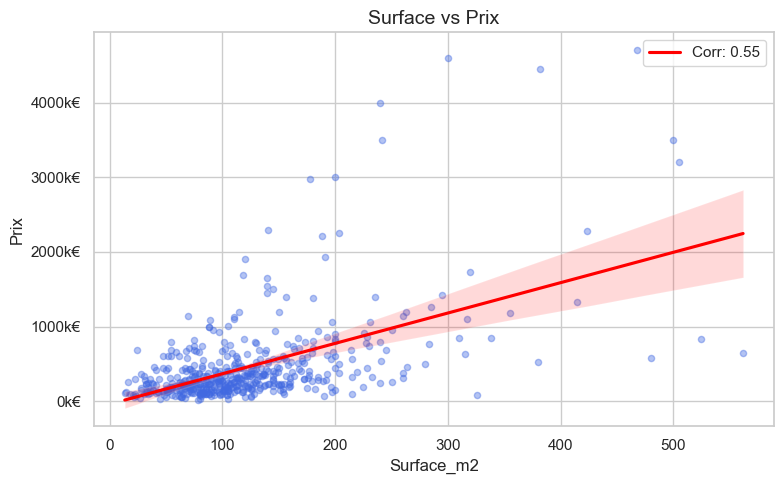

In [11]:
# Graphique
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

# Nuage de points et droite de régression
ax = sns.regplot(data=df, x='Surface_m2', y='Prix',
                 scatter_kws={'alpha':0.4, 'color':'royalblue', 's':20},
                 line_kws={'color':'red', 'label': f'Corr: {df["Surface_m2"].corr(df["Prix"]):.2f}'})
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k€'))

plt.title('Surface vs Prix', fontsize=14)
plt.legend()
plt.tight_layout()

On observe une corrélation positive modérée (coefficient de $0,55$). La droite rouge (droite de régression) monte, ce qui confirme la logique de base : plus la surface augmente, plus le prix a tendance à grimper.

On remarque que de nombreux points sont très éloignés de la ligne rouge. Cela indique que la surface n'est pas le seul critère déterminant du prix. Un petit bien à Paris peut coûter bien plus cher qu'une grande villa en province.

**7. Histogramme - Répartition des prix selon les régions**

Text(0.5, 0.98, 'Répartition des prix par Région (en k€)')

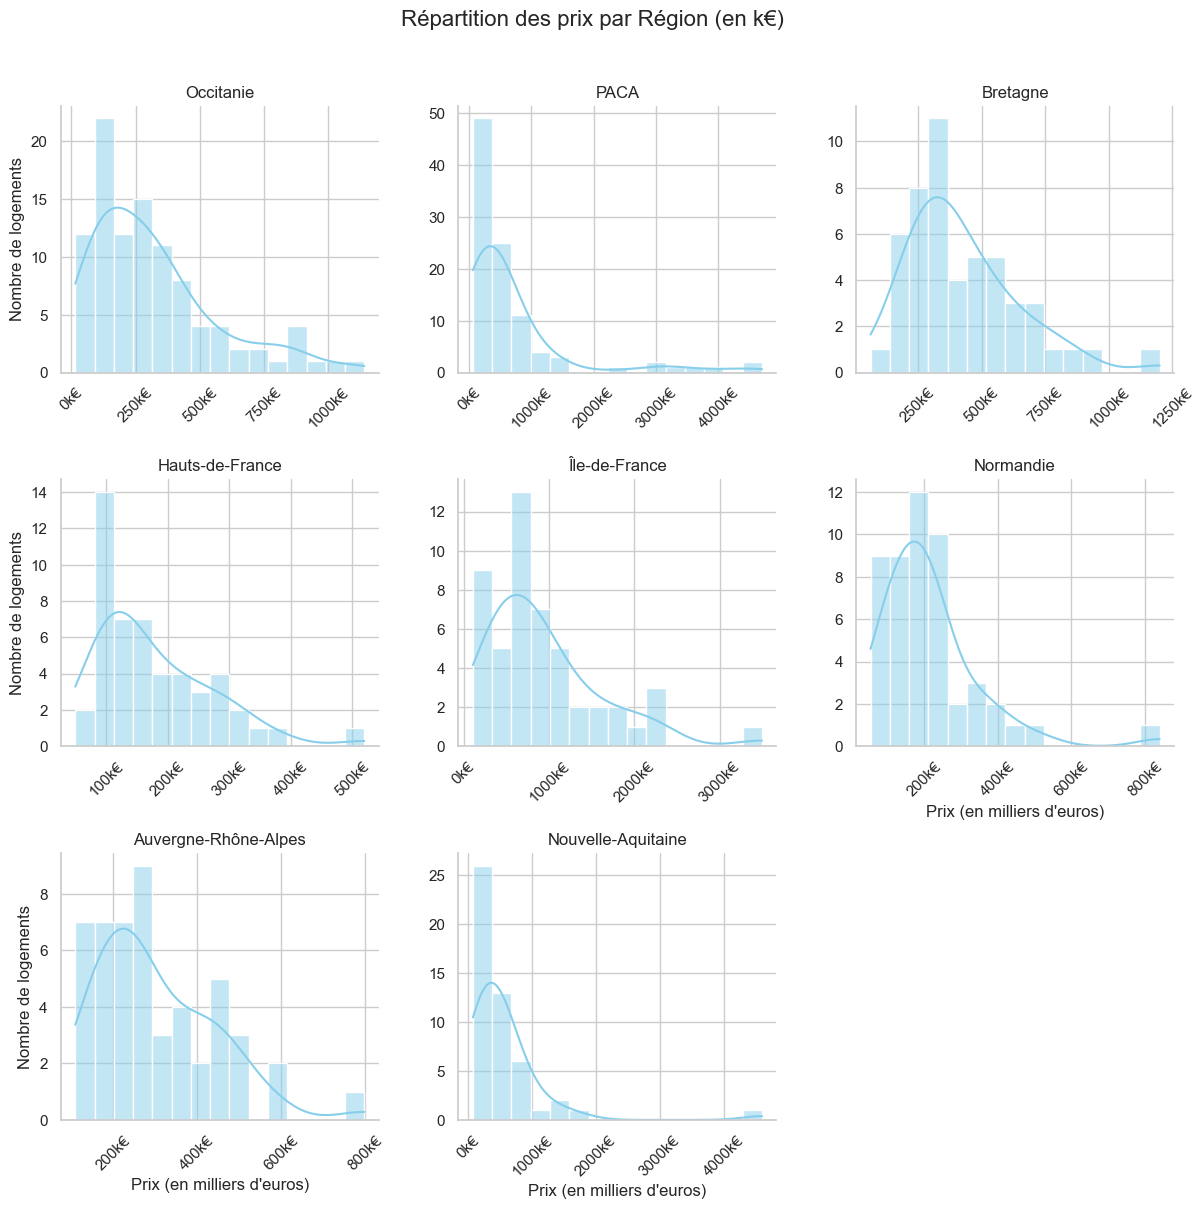

In [12]:
# Préparation des données
mapping_regions = {
    'Paris': 'Île-de-France', 'Marseille': 'PACA', 'Nice': 'PACA',
    'Lyon': 'Auvergne-Rhône-Alpes', 'Toulouse': 'Occitanie',
    'Montpellier': 'Occitanie', 'Bordeaux': 'Nouvelle-Aquitaine',
    'Lille': 'Hauts-de-France', 'Rennes': 'Bretagne', 'Rouen': 'Normandie'}
df['Region'] = df['Ville_Recherche'].map(mapping_regions)

# Configuration du graphique
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df, col="Region", col_wrap=3, height=4, sharex=False, sharey=False)

# Utilisation de l'histogramme
g.map(sns.histplot, "Prix", kde=True, bins=15, color="skyblue")

# FORCER le format des axes pour éviter la notation scientifique
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k€'))
    ax.tick_params(axis='x', rotation=45)

# Ajustements finaux
g.set_axis_labels("Prix (en milliers d'euros)", "Nombre de logements")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9, hspace=0.4)
g.figure.suptitle('Répartition des prix par Région (en k€)', fontsize=16)

*Île-de-France et PACA* : On observe une courbe très étalée vers la droite (longue traîne). La base de l'histogramme est large, ce qui montre une immense diversité de prix. Le fait que les barres s'étendent loin sur l'axe horizontal confirme que ces régions sont les seules à proposer régulièrement des biens dépassant le million d'euros.

*Hauts-de-France et Normandie* : Les graphiques présentent un pic très étroit et haut situé à gauche. La majorité des logements sont "entassés" dans les premières tranches de prix. Cette concentration massive au même endroit indique un marché accessible où la probabilité de trouver un bien à bas prix est très élevée.

*Nouvelle-Aquitaine et Occitanie* : Le "corps" de l'histogramme est centré sur des valeurs intermédiaires, mais on remarque des barres isolées totalement détachées du reste du groupe sur la droite. Ces barres représentent des micro-marchés de luxe qui ne reflètent pas la réalité de la majorité des transactions de la région.

**8. Boxplot - Répartition des prix selon les régions**

/var/folders/jm/r_7tyg2x43q_60q8vnp72dqr0000gn/T/ipykernel_99475/2446748457.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Region', y='Prix', data=df, palette="Set3")


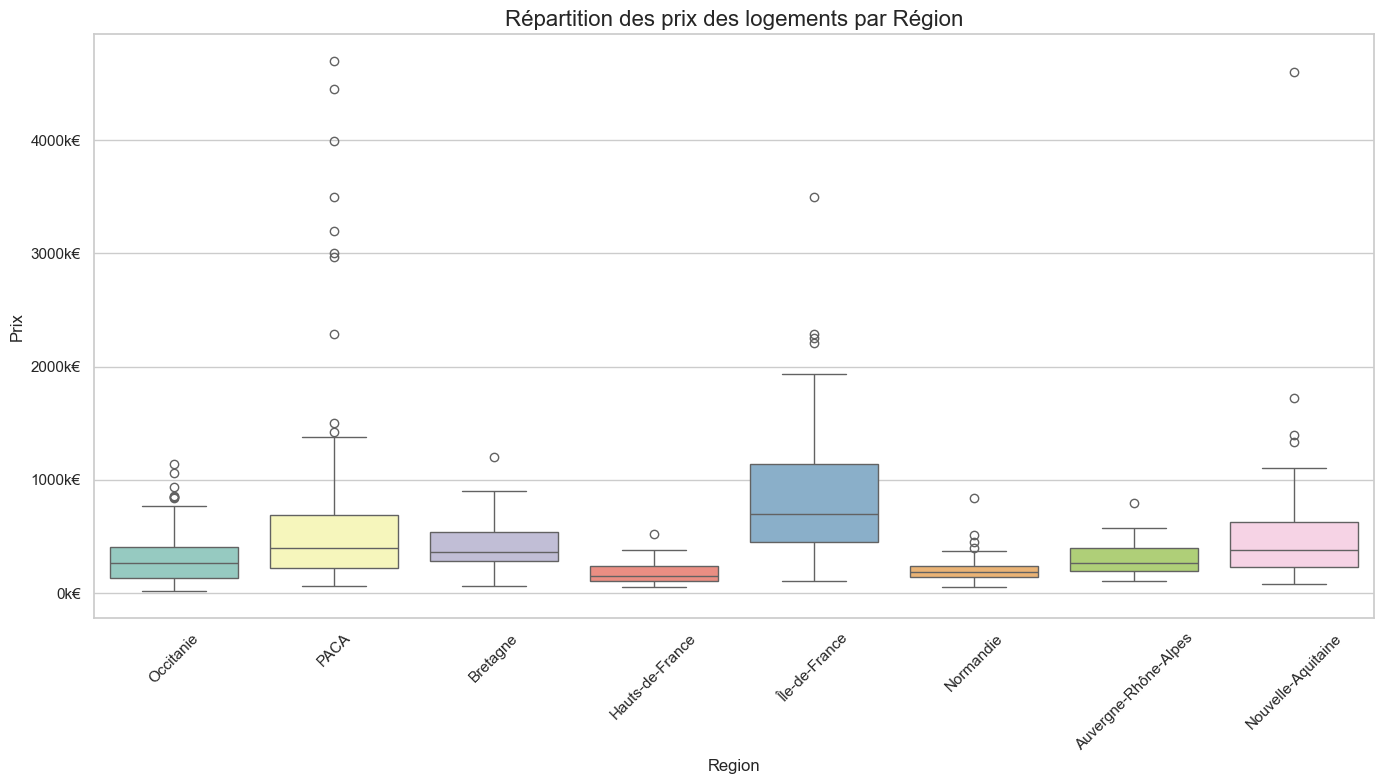

In [13]:
# Chargement et préparation
mapping_regions = {
    'Paris': 'Île-de-France', 'Marseille': 'PACA', 'Nice': 'PACA',
    'Lyon': 'Auvergne-Rhône-Alpes', 'Toulouse': 'Occitanie',
    'Montpellier': 'Occitanie', 'Bordeaux': 'Nouvelle-Aquitaine',
    'Lille': 'Hauts-de-France', 'Rennes': 'Bretagne', 'Rouen': 'Normandie'}
df['Region'] = df['Ville_Recherche'].map(mapping_regions)

# Création du graphique
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x='Region', y='Prix', data=df, palette="Set3")

# Formatage des axes
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k€'))
plt.xticks(rotation=45)
plt.title('Répartition des prix des logements par Région', fontsize=16)
plt.tight_layout()



*Île-de-France et PACA* : On remarque que les boîtes sont situées plus haut que les autres, ce qui confirme que ces régions sont les plus onéreuses. On voit également des "outliers" situés très hauts, ce qui indique la présence de biens d'exception (plusieurs millions d'euros).

*Hauts-de-France et Normandie* : Les boîtes sont plus basses et plus "serrées", indiquant des prix plus abordables et plus homogènes.

*Nouvelle-Aquitaine* : Notez le point très élevé tout en haut ; il s'agit d'une valeur extrême (probablement une propriété de luxe à Bordeaux) qui tire la moyenne vers le haut, alors que la médiane reste plus basse.

**IV. Visualisation cartographique**

In [14]:
# Création de la carte interactive
fig = px.scatter_mapbox(df,
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Type",
                        hover_data={
                            "Prix": ":,d",
                            "Ville_Reelle": True,
                            "Surface_m2": True,
                            "Latitude": False,
                            "Longitude": False},
                        color="Type",
                        color_discrete_map={'Maison': 'red', 'Appartement': 'blue'},
                        zoom=5,
                        height=600,
                        title="Carte Interactive des Logements (Prix au survol)")

# Configuration du fond de carte (OpenStreetMap)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

# Représentation visuelle
fig.show()

/var/folders/jm/r_7tyg2x43q_60q8vnp72dqr0000gn/T/ipykernel_99475/3837420100.py:2: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(df,


La couleur bleue représente les appartements et le rouge les maisons. La densité des points permet de visualiser les zones de forte activité notariale.